# `CNModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+7.gdcf859e.dirty


## `supplement_mol_data`

Here we model the hyperfine structure of CN emission. We use the helper function `supplement_mol_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import supplement_mol_data

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])
print("state info", mol_data_12CN["states"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.9743

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

12CN-1 550
12CN-2 300


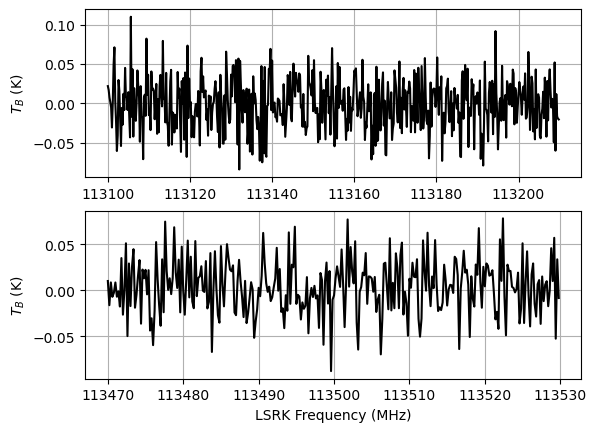

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, dummy_data["12CN-1"].brightness, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, dummy_data["12CN-2"].brightness, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.


Tex
[[4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]
 [4.46683592 3.98107171 3.16227766]]

tau
[[0.02780937 0.03961643 0.06312223]
 [0.22764058 0.32429648 0.51673788]
 [0.2223333  0.31672379 0.5046276 ]
 [0.28871089 0.41128963 0.65532851]
 [0.28981529 0.41280405 0.65753902]
 [0.76986139 1.09659601 1.7468342 ]
 [0.22866526 0.32570236 0.51879336]
 [0.22339835 0.31820796 0.50688522]
 [0.02794853 0.03980962 0.06341362]]

tau_total
[2.30618295 3.28504631 5.23328165]

TR
[[2.28910526 1.86520154 1.1888105 ]
 [2.28879859 1.86491585 1.18857141]
 [2.28841062 1.86455441 1.18826896]
 [2.2881045  1.86426923 1.18803032]
 [2.28373743 1.86020143 1.1846276 ]
 [2.28369563 1.8601625  1.18459504]
 [2.28356835 1.86004396 1.18449591]
 [2.28343176 1.85991675 1.18438954]
 [

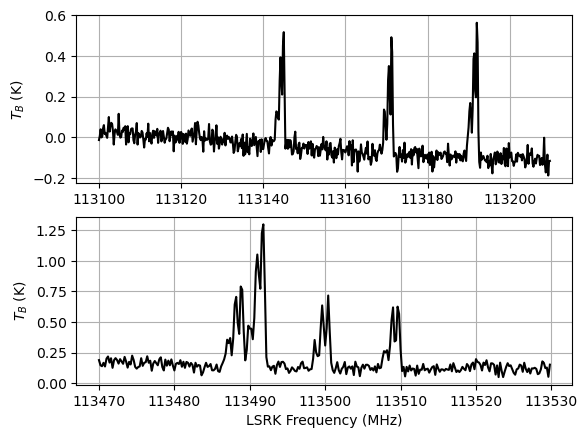

In [4]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX = True, # assume CTEX
    prior_LTE_precision = None, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

derived_params = ["Tex", "tau", "tau_total", "TR"]
derived_params = {
    param: model.model[param].eval(sim_params, on_unused_input="ignore")
    for param in derived_params
}

for key, value in derived_params.items():
    print()
    print(key)
    print(value)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

12CN-1 550
12CN-2 300


## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 1.0], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX = True, # assume CTEX
    prior_LTE_precision = None, # ignored for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

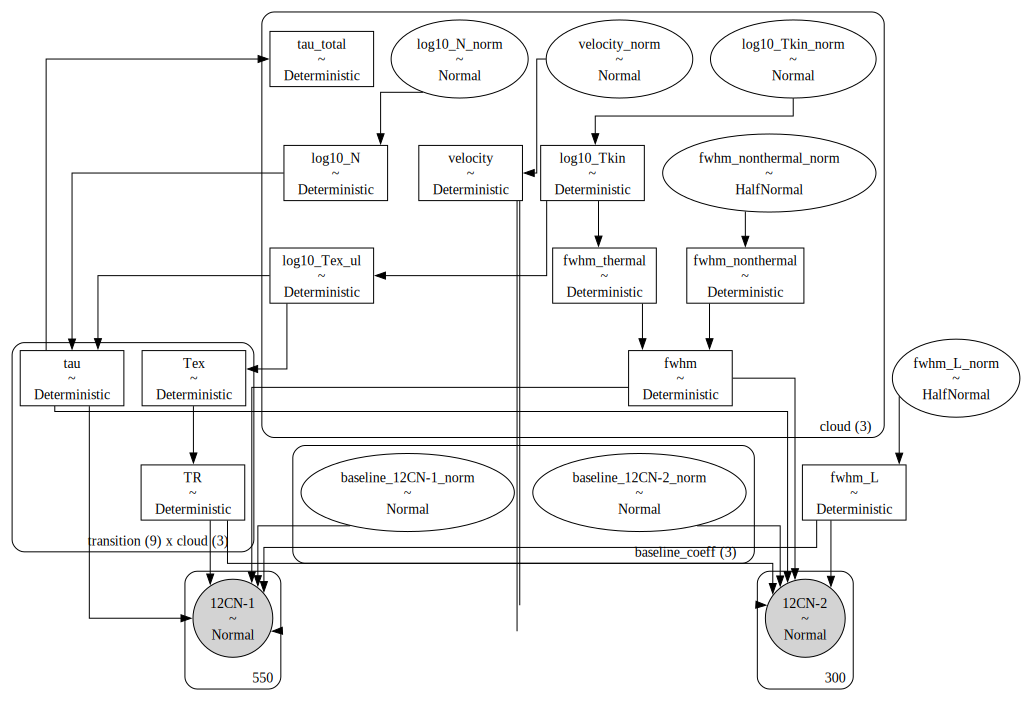

In [7]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, <constant>)
baseline_12CN-2_norm ~ Normal(0, <constant>)
       velocity_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
         fwhm_L_norm ~ HalfNormal(0, 1)
        log10_N_norm ~ Normal(0, 1)
            velocity ~ Deterministic(f(velocity_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
        fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
              fwhm_L ~ Deterministic(f(fwhm_L_norm))
             log10_N ~ Deterministic(f(log10_N_norm))
        log10_Tex_ul ~ Deterministic(f(log10_Tkin_norm))
                 Tex ~ Deterministic(f(log10_Tkin_norm))
                 tau ~ Deterministic(f(log10_N_norm, log10_Tkin_norm))
           tau_total ~ Deterministic(f(log10_N_norm, log10_Tkin_norm))
                  TR ~ Deterministic(f(log10_Tkin

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tkin_norm, velocity_norm]


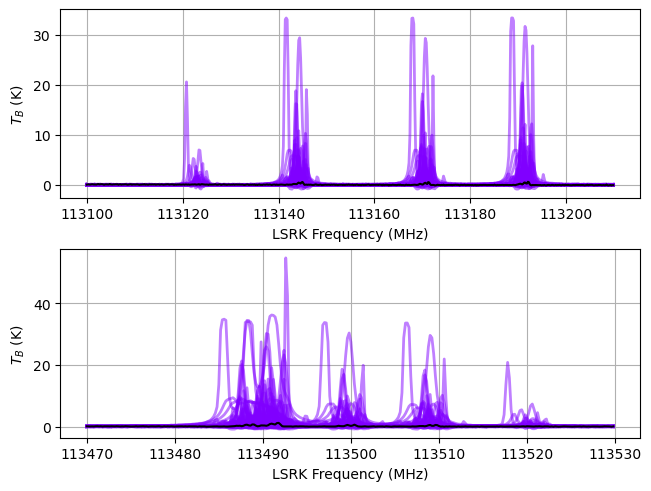

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5900
Interrupted at 5,899 [5%]: Average Loss = 4,298.4


Output()

Runtime: 3.01 minutes


In [11]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               2.566  0.038   2.494    2.634      0.001    0.001   
velocity[1]               0.005  0.015  -0.020    0.037      0.000    0.000   
velocity[2]              -1.985  0.011  -2.008   -1.967      0.000    0.000   
log10_Tkin[0]             0.502  0.002   0.498    0.506      0.000    0.000   
log10_Tkin[1]             0.610  0.004   0.603    0.616      0.000    0.000   
log10_Tkin[2]             0.655  0.003   0.649    0.660      0.000    0.000   
fwhm_thermal[0]           0.075  0.000   0.074    0.075      0.000    0.000   
fwhm_thermal[1]           0.085  0.000   0.084    0.085      0.000    0.000   
fwhm_thermal[2]           0.089  0.000   0.089    0.090      0.000    0.000   
fwhm_nonthermal[0]        1.450  0.084   1.300    1.608      0.003    0.002   
fwhm_nonthermal[1]        1.291  0.035   1.228    1.356      0.001    0.001   
fwhm_nonthermal[2]        1.012  0.023   0.967    1.052      0.001    0.001   
fwhm[0]                   1.452  0.084   1.302    1.609      0.003    0.002   
fwhm[1]                   1.294  0.035   1.231    1.359      0.001    0.001   
fwhm[2]                   1.016  0.023   0.971    1.056      0.001    0.001   
log10_N[0]               13.973  0.026  13.925   14.023      0.001    0.001   
log10_N[1]               13.872  0.009  13.856   13.889      0.000    0.000   
log10_N[2]               13.790  0.008  13.776   13.805      0.000    0.000   
log10_Tex_ul[0]           0.502  0.002   0.498    0.506      0.000    0.000   
log10_Tex_ul[1]           0.610  0.004   0.603    0.616      0.000    0.000   
log10_Tex_ul[2]           0.655  0.003   0.649    0.660      0.000    0.000   
tau_total[0]              4.897  0.298   4.300    5.408      0.010    0.007   
tau_total[1]              3.006  0.067   2.885    3.136      0.002    0.002   
tau_total[2]              2.227  0.045   2.146    2.310      0.001    0.001   
fwhm_L                    0.026  0.023   0.002    0.067      0.001    0.001   
baseline_12CN-1_norm[0]  -0.303  0.049  -0.389   -0.200      0.002    0.001   
baseline_12CN-1_norm[1]  -4.868  0.157  -5.158   -4.576      0.005    0.004   
baseline_12CN-1_norm[2]   2.490  0.700   1.240    3.932      0.022    0.016   
baseline_12CN-2_norm[0]  -0.496  0.068  -0.622   -0.377      0.002    0.002   
baseline_12CN-2_norm[1]  -1.885  0.230  -2.303   -1.450      0.008    0.005   
baseline_12CN-2_norm[2]   2.148  0.822   0.613    3.653      0.029    0.021   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                 943.0     981.0    NaN  
velocity[1]                1080.0    1026.0    NaN  
velocity[2]                 966.0     914.0    NaN  
log10_Tkin[0]               963.0     840.0    NaN  
log10_Tkin[1]               945.0     798.0    NaN  
log10_Tkin[2]               780.0     847.0    NaN  
fwhm_thermal[0]             963.0     840.0    NaN  
fwhm_thermal[1]             945.0     798.0    NaN  
fwhm_thermal[2]             780.0     847.0    NaN  
fwhm_nonthermal[0]         1069.0     940.0    NaN  
fwhm_nonthermal[1]          999.0     944.0    NaN  
fwhm_nonthermal[2]          956.0     982.0    NaN  
fwhm[0]                    1069.0     940.0    NaN  
fwhm[1]                     999.0     944.0    NaN  
fwhm[2]                     956.0     982.0    NaN  
log10_N[0]                  921.0     689.0    NaN  
log10_N[1]                  977.0    1023.0    NaN  
log10_N[2]                  932.0     944.0    NaN  
log10_Tex_ul[0]             963.0     840.0    NaN  
log10_Tex_ul[1]             945.0     798.0    NaN  
log10_Tex_ul[2]             780.0     847.0    NaN  
tau_total[0]                960.0     816.0    NaN  
tau_total[1]                976.0     981.0    NaN  
tau_total[2]                954.0     827.0    NaN  
fwhm_L                      961.0     982.0    NaN  
baseline_12CN-1_norm[0]    1040.0     979.0    NaN  
baseline_12CN-1_norm[1]     963.0     942.0    NaN  
baseline_12CN-

Sampling: [12CN-1, 12CN-2]


Output()

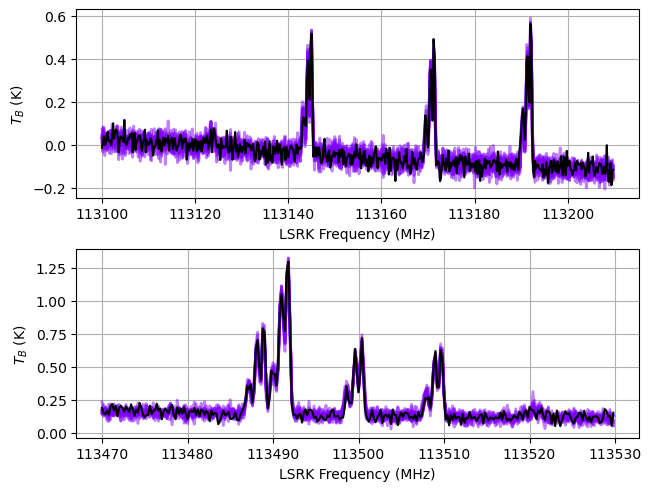

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5900
Interrupted at 5,899 [5%]: Average Loss = 4,298.4
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 161 seconds.


Adding log-likelihood to trace


Output()

Runtime: 4.42 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               2.536  0.036   2.467    2.599      0.000    0.000   
velocity[1]               0.007  0.015  -0.021    0.035      0.000    0.000   
velocity[2]              -1.981  0.010  -2.000   -1.962      0.000    0.000   
log10_Tkin[0]             0.502  0.006   0.492    0.514      0.000    0.000   
log10_Tkin[1]             0.610  0.007   0.597    0.624      0.000    0.000   
log10_Tkin[2]             0.657  0.008   0.641    0.672      0.000    0.000   
fwhm_thermal[0]           0.075  0.001   0.074    0.076      0.000    0.000   
fwhm_thermal[1]           0.085  0.001   0.083    0.086      0.000    0.000   
fwhm_thermal[2]           0.089  0.001   0.088    0.091      0.000    0.000   
fwhm_nonthermal[0]        1.452  0.091   1.282    1.626      0.001    0.001   
fwhm_nonthermal[1]        1.290  0.042   1.210    1.367      0.001    0.000   
fwhm_nonthermal[2]        1.005  0.027   0.955    1.053      0.000    0.000   
fwhm[0]                   1.454  0.091   1.283    1.627      0.001    0.001   
fwhm[1]                   1.293  0.041   1.213    1.370      0.001    0.000   
fwhm[2]                   1.009  0.026   0.960    1.057      0.000    0.000   
log10_N[0]               13.967  0.062  13.850   14.082      0.001    0.001   
log10_N[1]               13.876  0.026  13.828   13.924      0.000    0.000   
log10_N[2]               13.792  0.022  13.748   13.832      0.000    0.000   
log10_Tex_ul[0]           0.502  0.006   0.492    0.514      0.000    0.000   
log10_Tex_ul[1]           0.610  0.007   0.597    0.624      0.000    0.000   
log10_Tex_ul[2]           0.657  0.008   0.641    0.672      0.000    0.000   
tau_total[0]              4.884  0.751   3.525    6.339      0.009    0.007   
tau_total[1]              3.039  0.229   2.618    3.471      0.003    0.002   
tau_total[2]              2.230  0.157   1.932    2.520      0.002    0.002   
fwhm_L                    0.025  0.022   0.000    0.065      0.000    0.000   
baseline_12CN-1_norm[0]  -0.292  0.052  -0.390   -0.194      0.001    0.000   
baseline_12CN-1_norm[1]  -4.881  0.144  -5.141   -4.607      0.001    0.001   
baseline_12CN-1_norm[2]   2.518  0.785   1.038    3.989      0.009    0.006   
baseline_12CN-2_norm[0]  -0.494  0.073  -0.633   -0.358      0.001    0.001   
baseline_12CN-2_norm[1]  -1.881  0.197  -2.250   -1.509      0.002    0.001   
baseline_12CN-2_norm[2]   2.123  0.878   0.365    3.690      0.009    0.007   

                         ess_bulk  ess_tail  r_hat  
velocity[0]               11200.0    6106.0    1.0  
velocity[1]                8349.0    5860.0    1.0  
velocity[2]                7705.0    6400.0    1.0  
log10_Tkin[0]              6009.0    4116.0    1.0  
log10_Tkin[1]              5153.0    4306.0    1.0  
log10_Tkin[2]              5423.0    5473.0    1.0  
fwhm_thermal[0]            6009.0    4116.0    1.0  
fwhm_thermal[1]            5153.0    4306.0    1.0  
fwhm_thermal[2]            5423.0    5473.0    1.0  
fwhm_nonthermal[0]         9173.0    5554.0    1.0  
fwhm_nonthermal[1]         6876.0    6160.0    1.0  
fwhm_nonthermal[2]         7361.0    6233.0    1.0  
fwhm[0]                    9171.0    5554.0    1.0  
fwhm[1]                    6874.0    6134.0    1.0  
fwhm[2]                    7352.0    6307.0    1.0  
log10_N[0]                 6143.0    4009.0    1.0  
log10_N[1]                 5389.0    4622.0    1.0  
log10_N[2]                 5266.0    5541.0    1.0  
log10_Tex_ul[0]            6009.0    4116.0    1.0  
log10_Tex_ul[1]            5153.0    4306.0    1.0  
log10_Tex_ul[2]            5423.0    5473.0    1.0  
tau_total[0]               6109.0    3937.0    1.0  
tau_total[1]               5276.0    4697.0    1.0  
tau_total[2]               5229.0    5248.0    1.0  
fwhm_L                     8193.0    4197.0    1.0  
baseline_12CN-1_norm[0]    8853.0    6671.0    1.0  
baseline_12CN-1_norm[1]   12171.0    5928.0    1.0  
baseline_12CN-

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [12CN-1, 12CN-2]


Output()

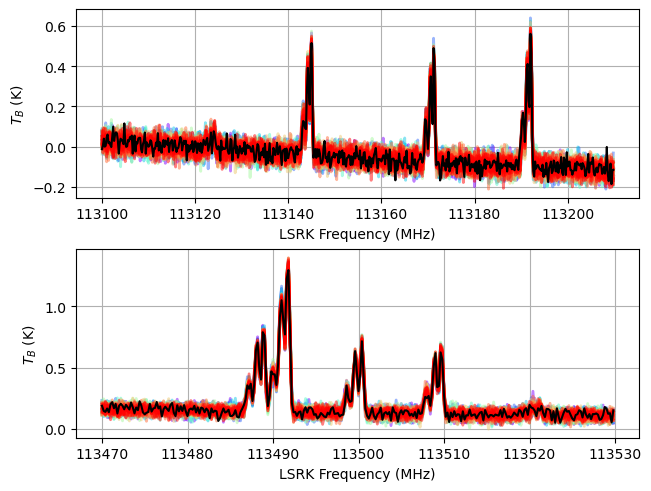

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

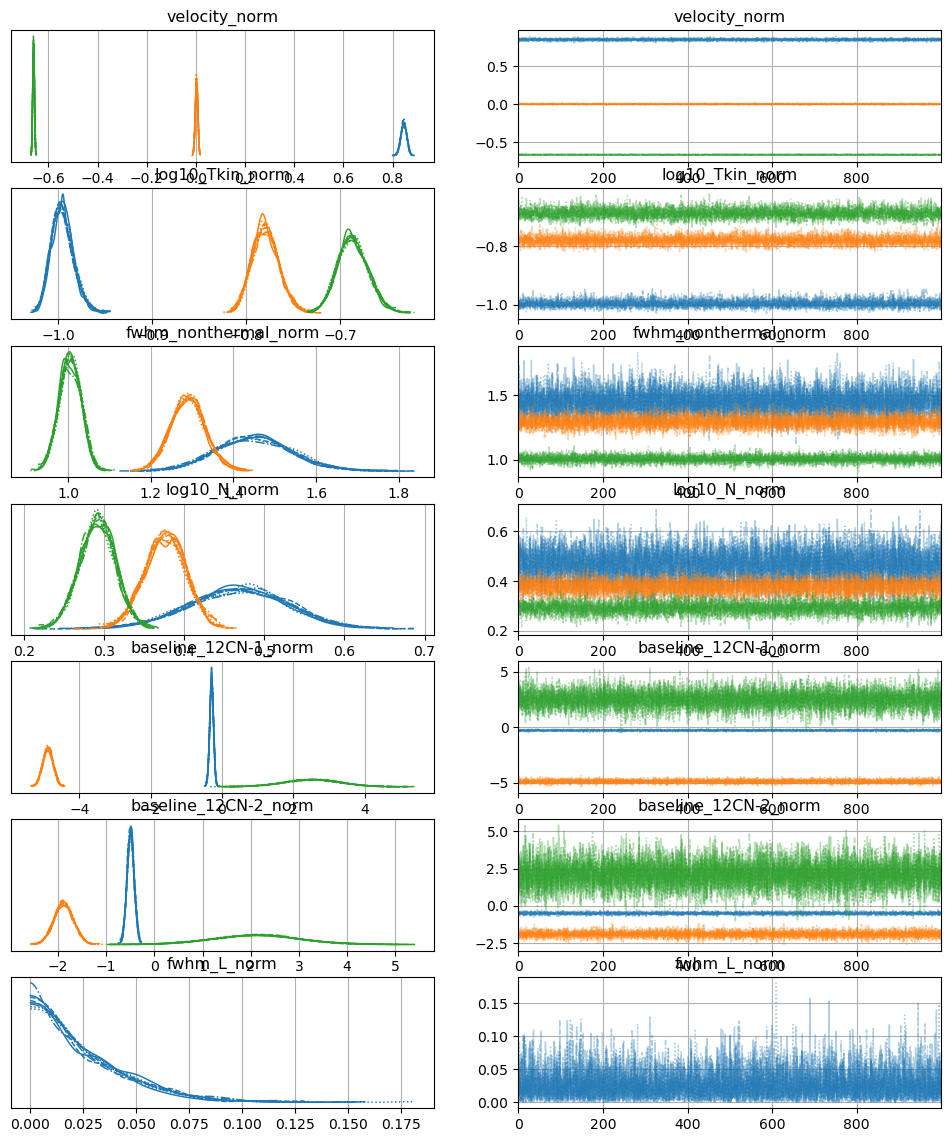

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

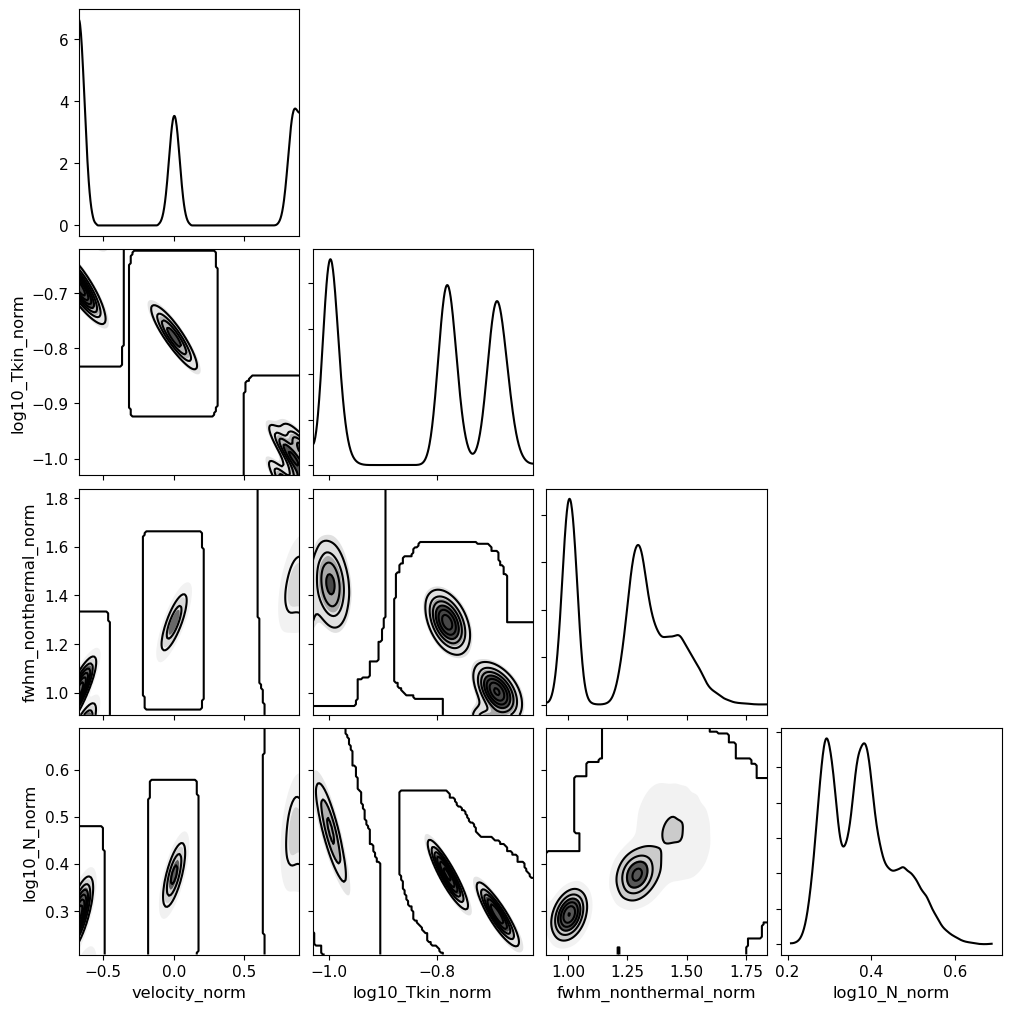

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

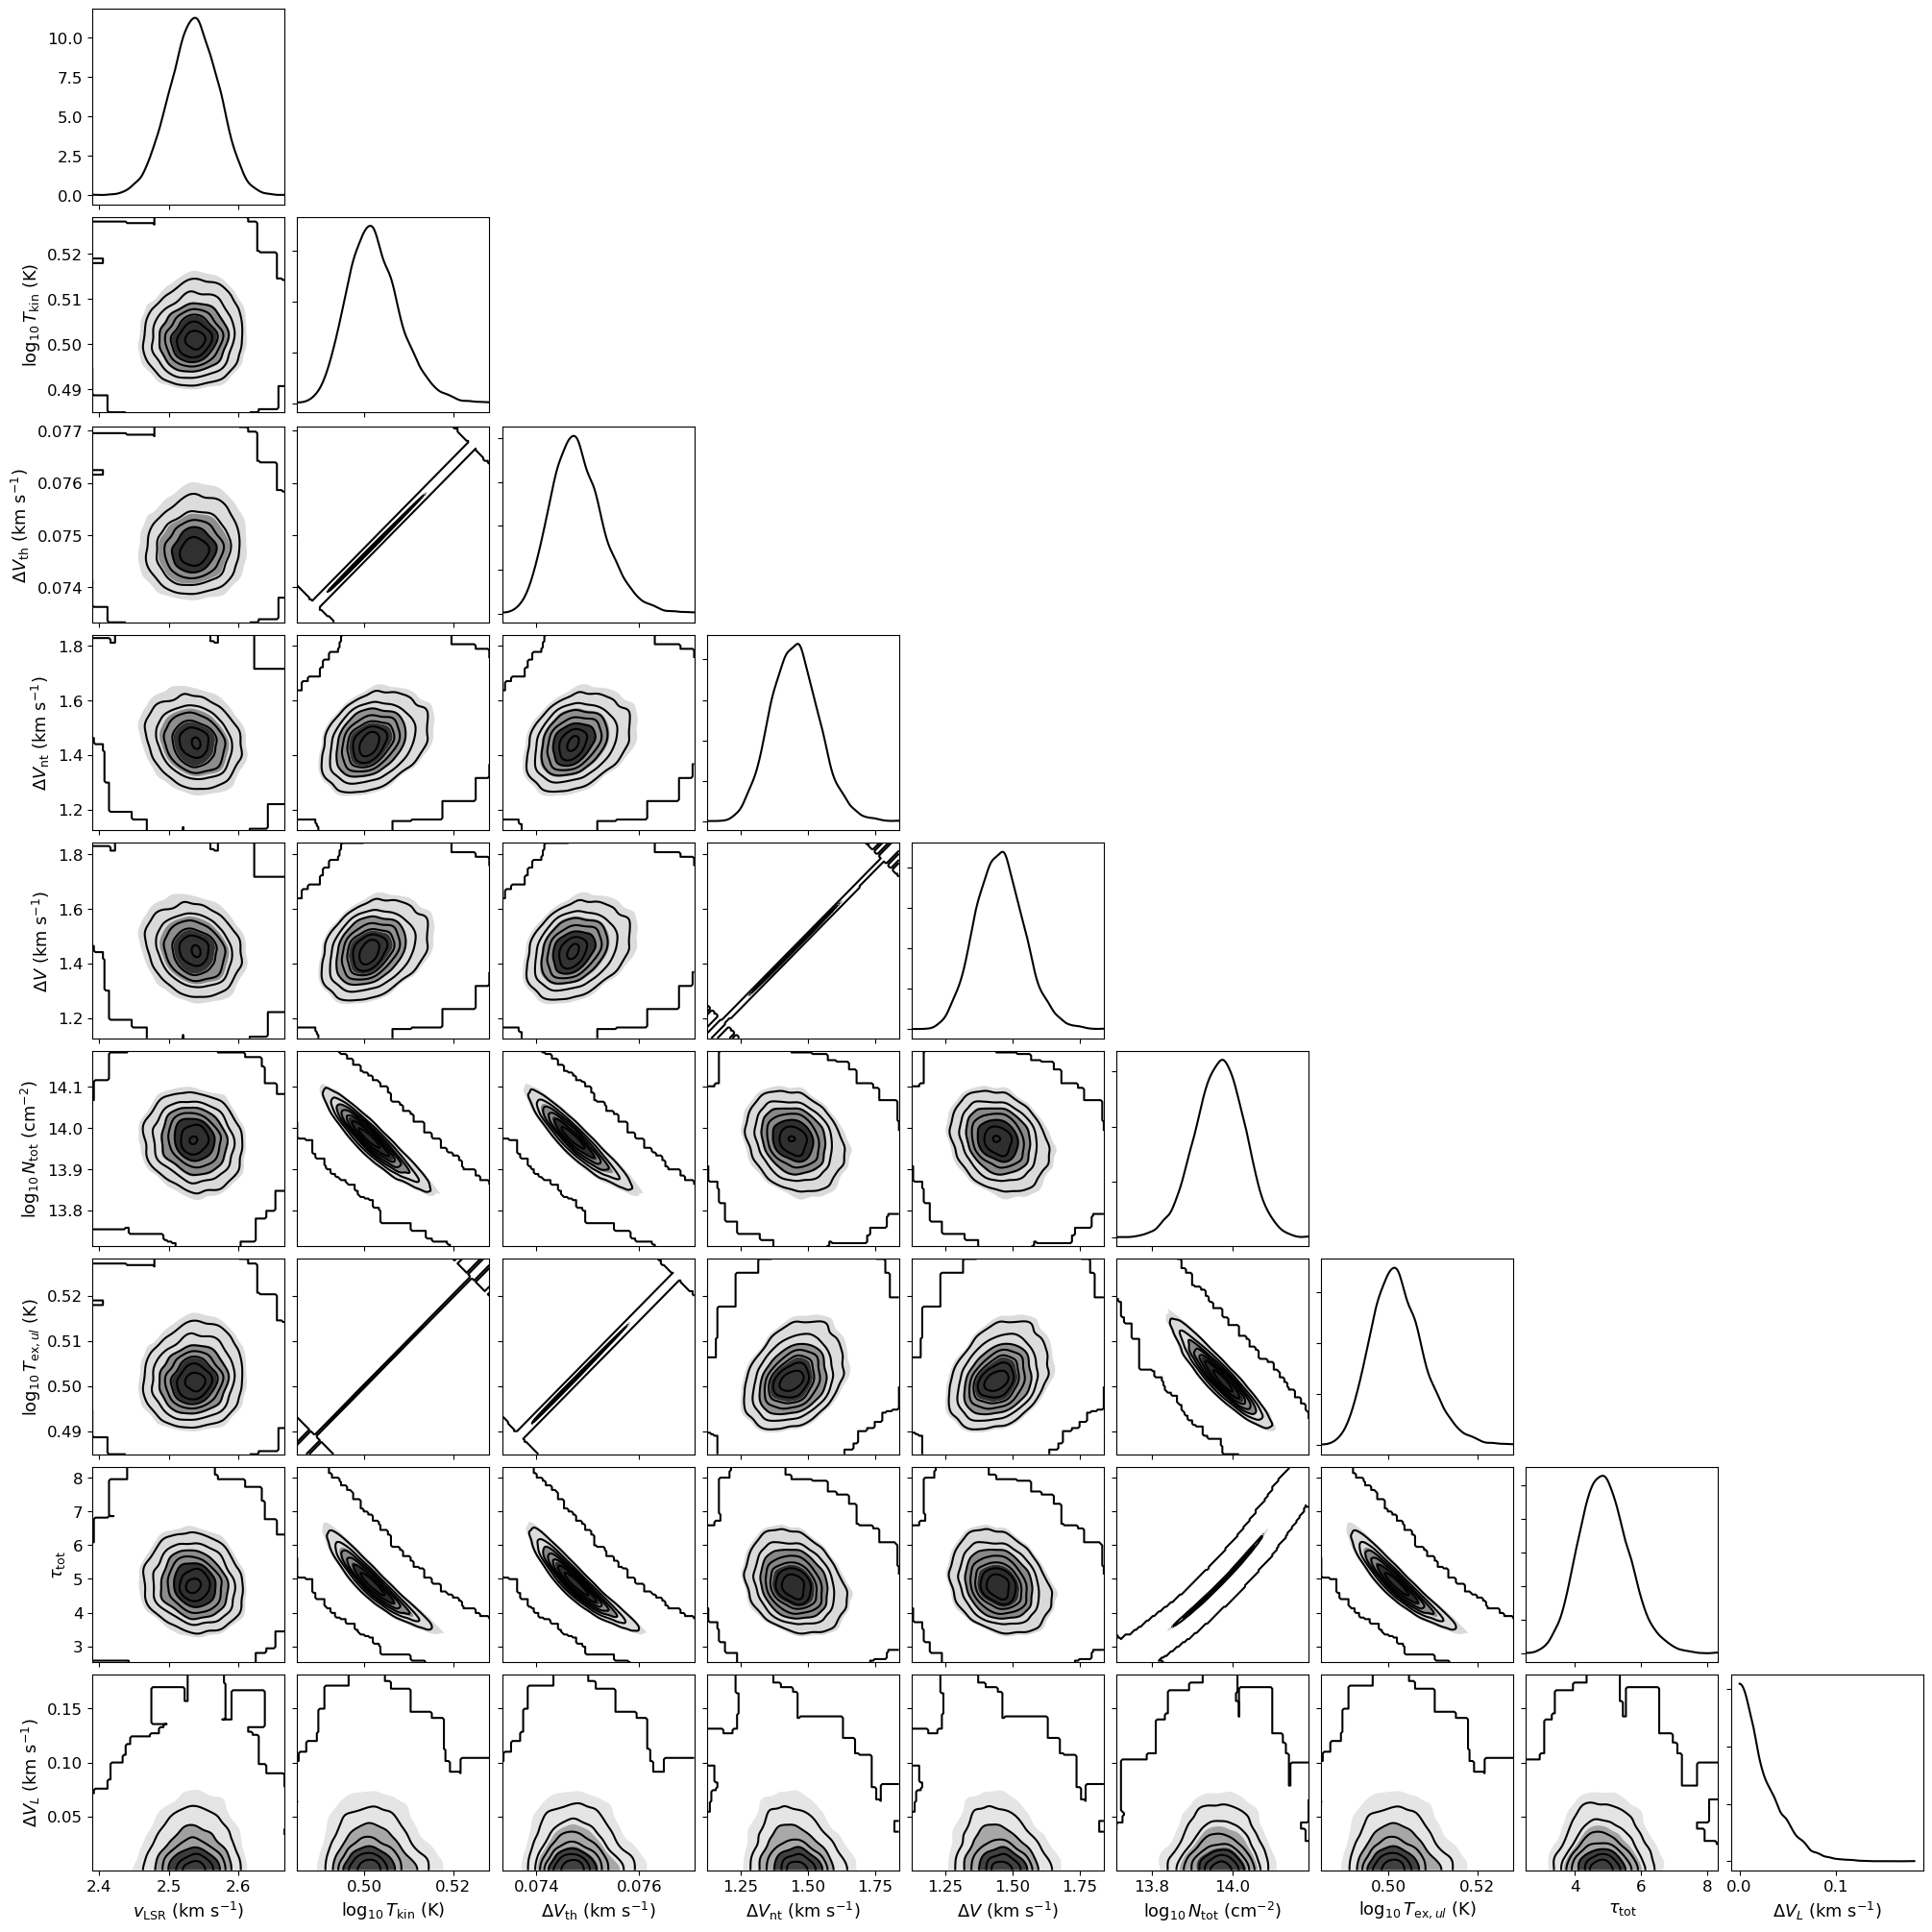

In [19]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

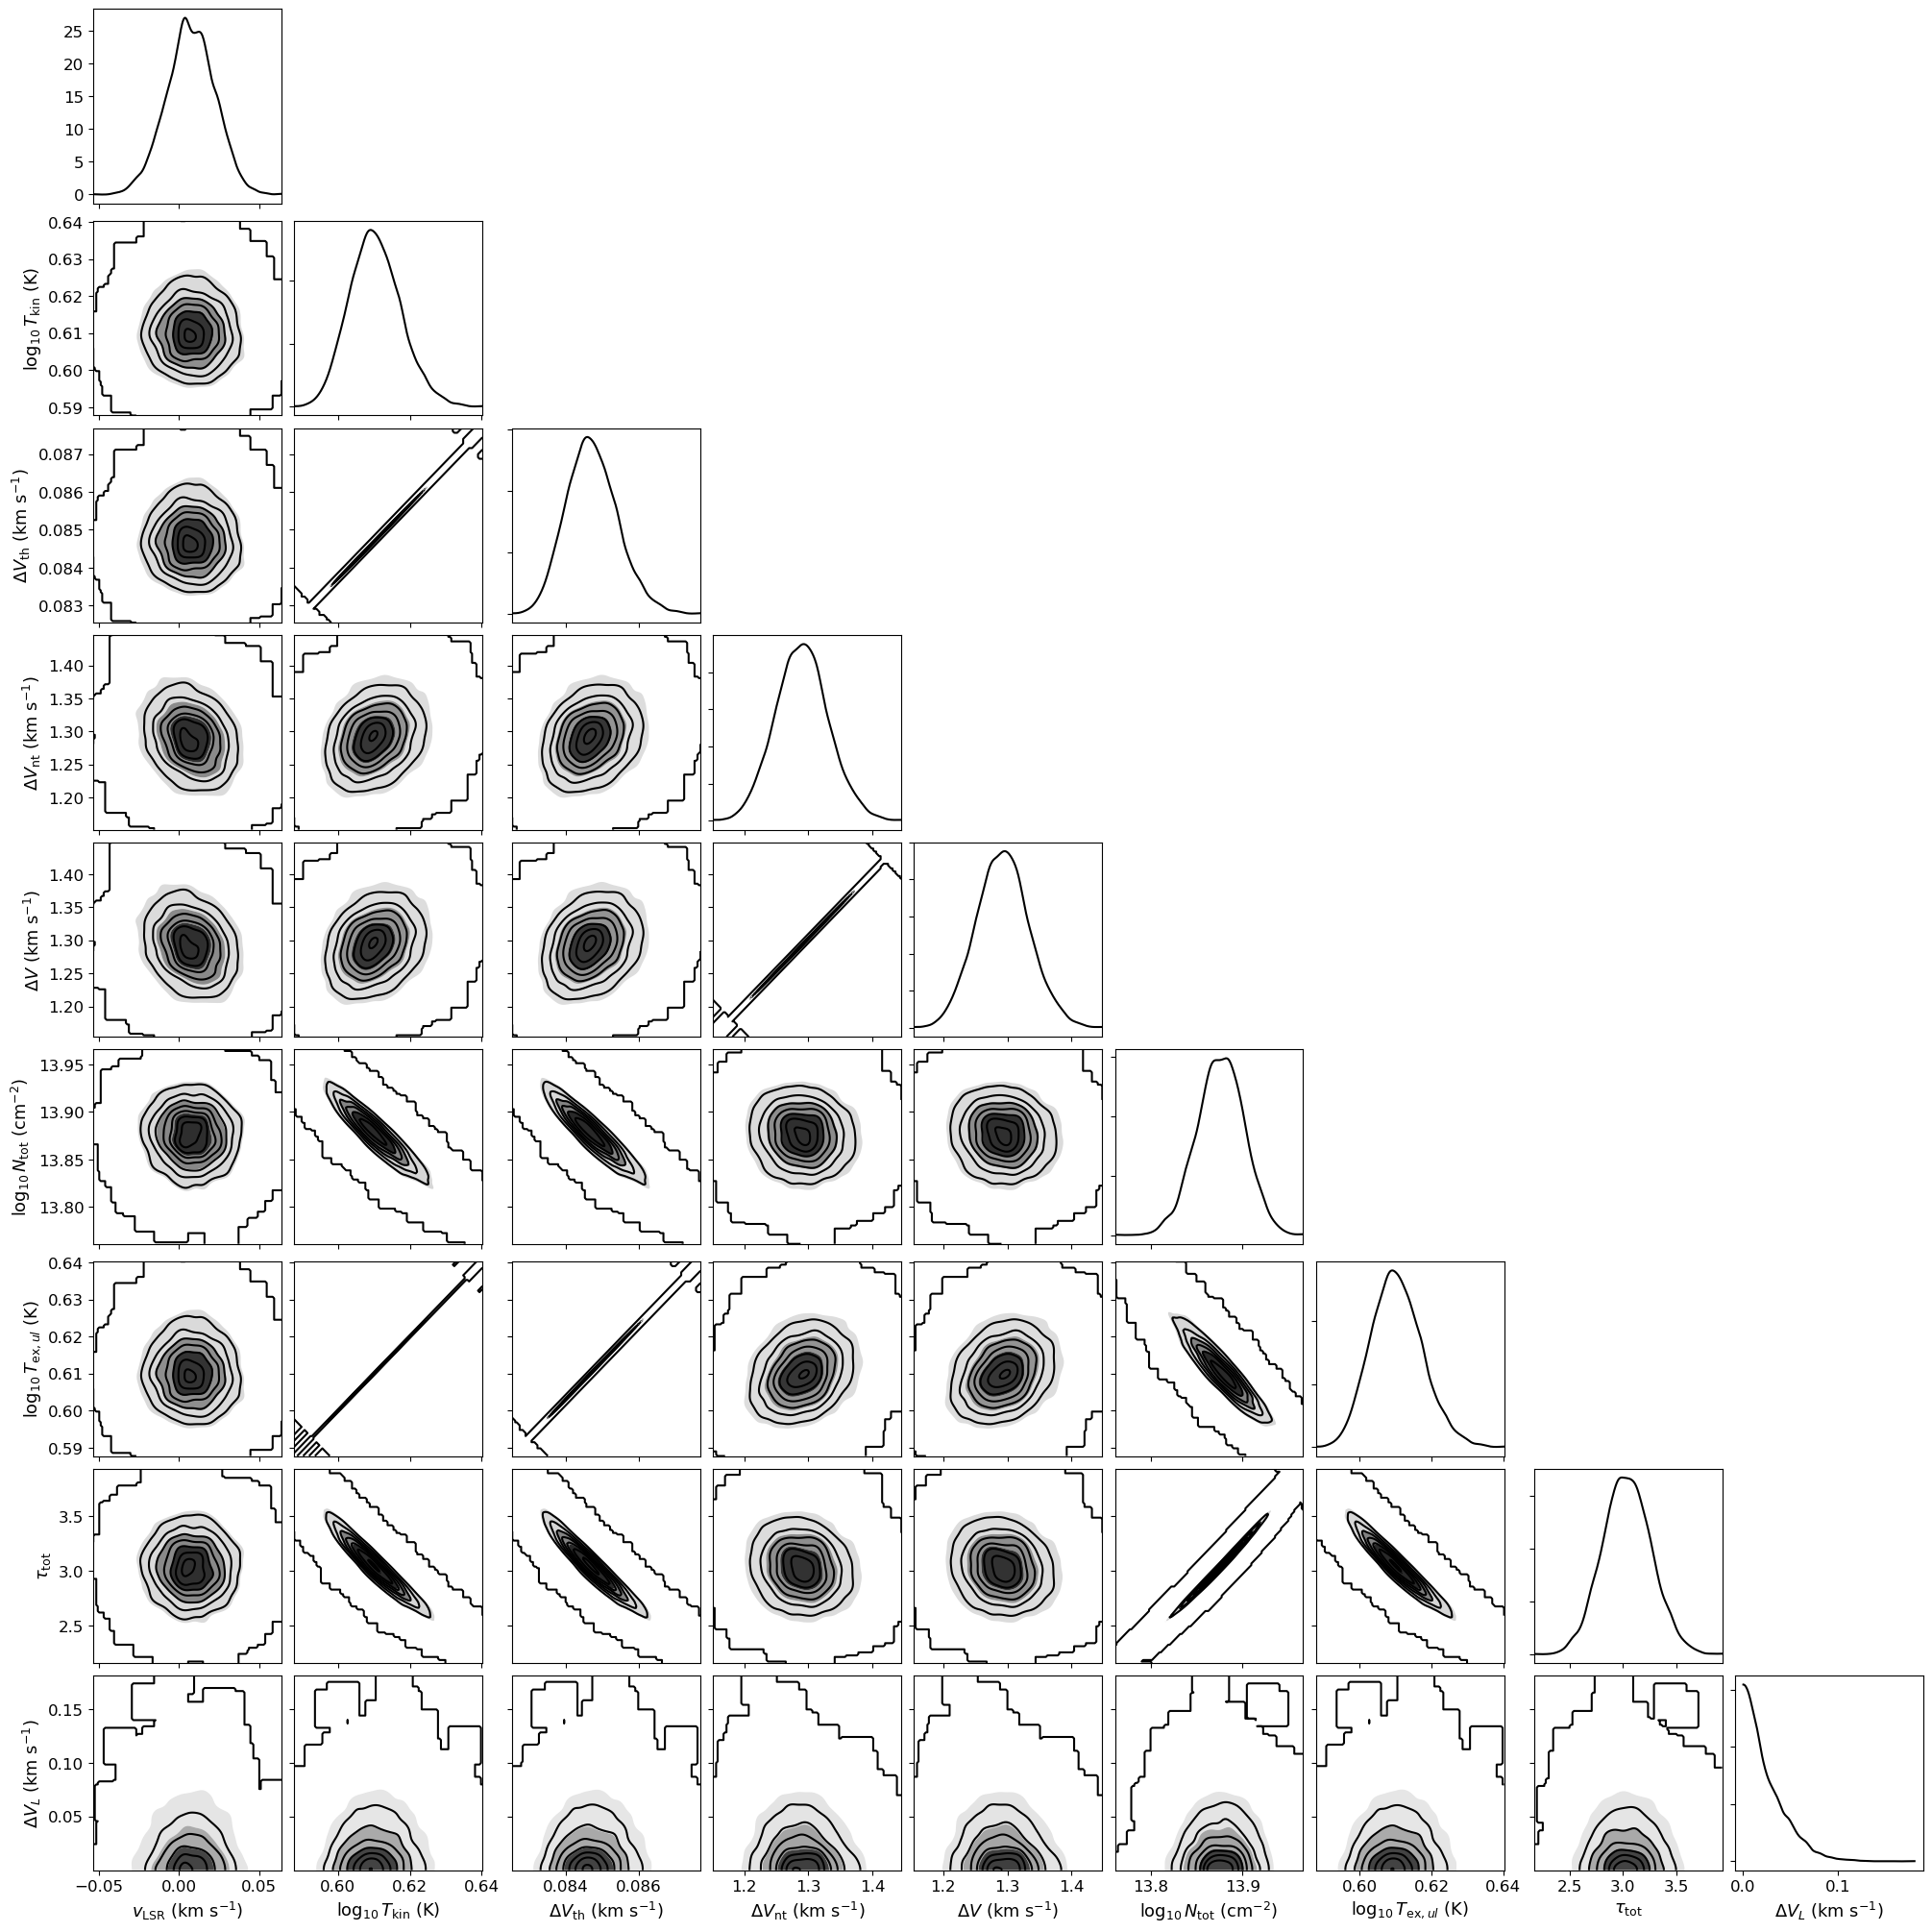

In [20]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

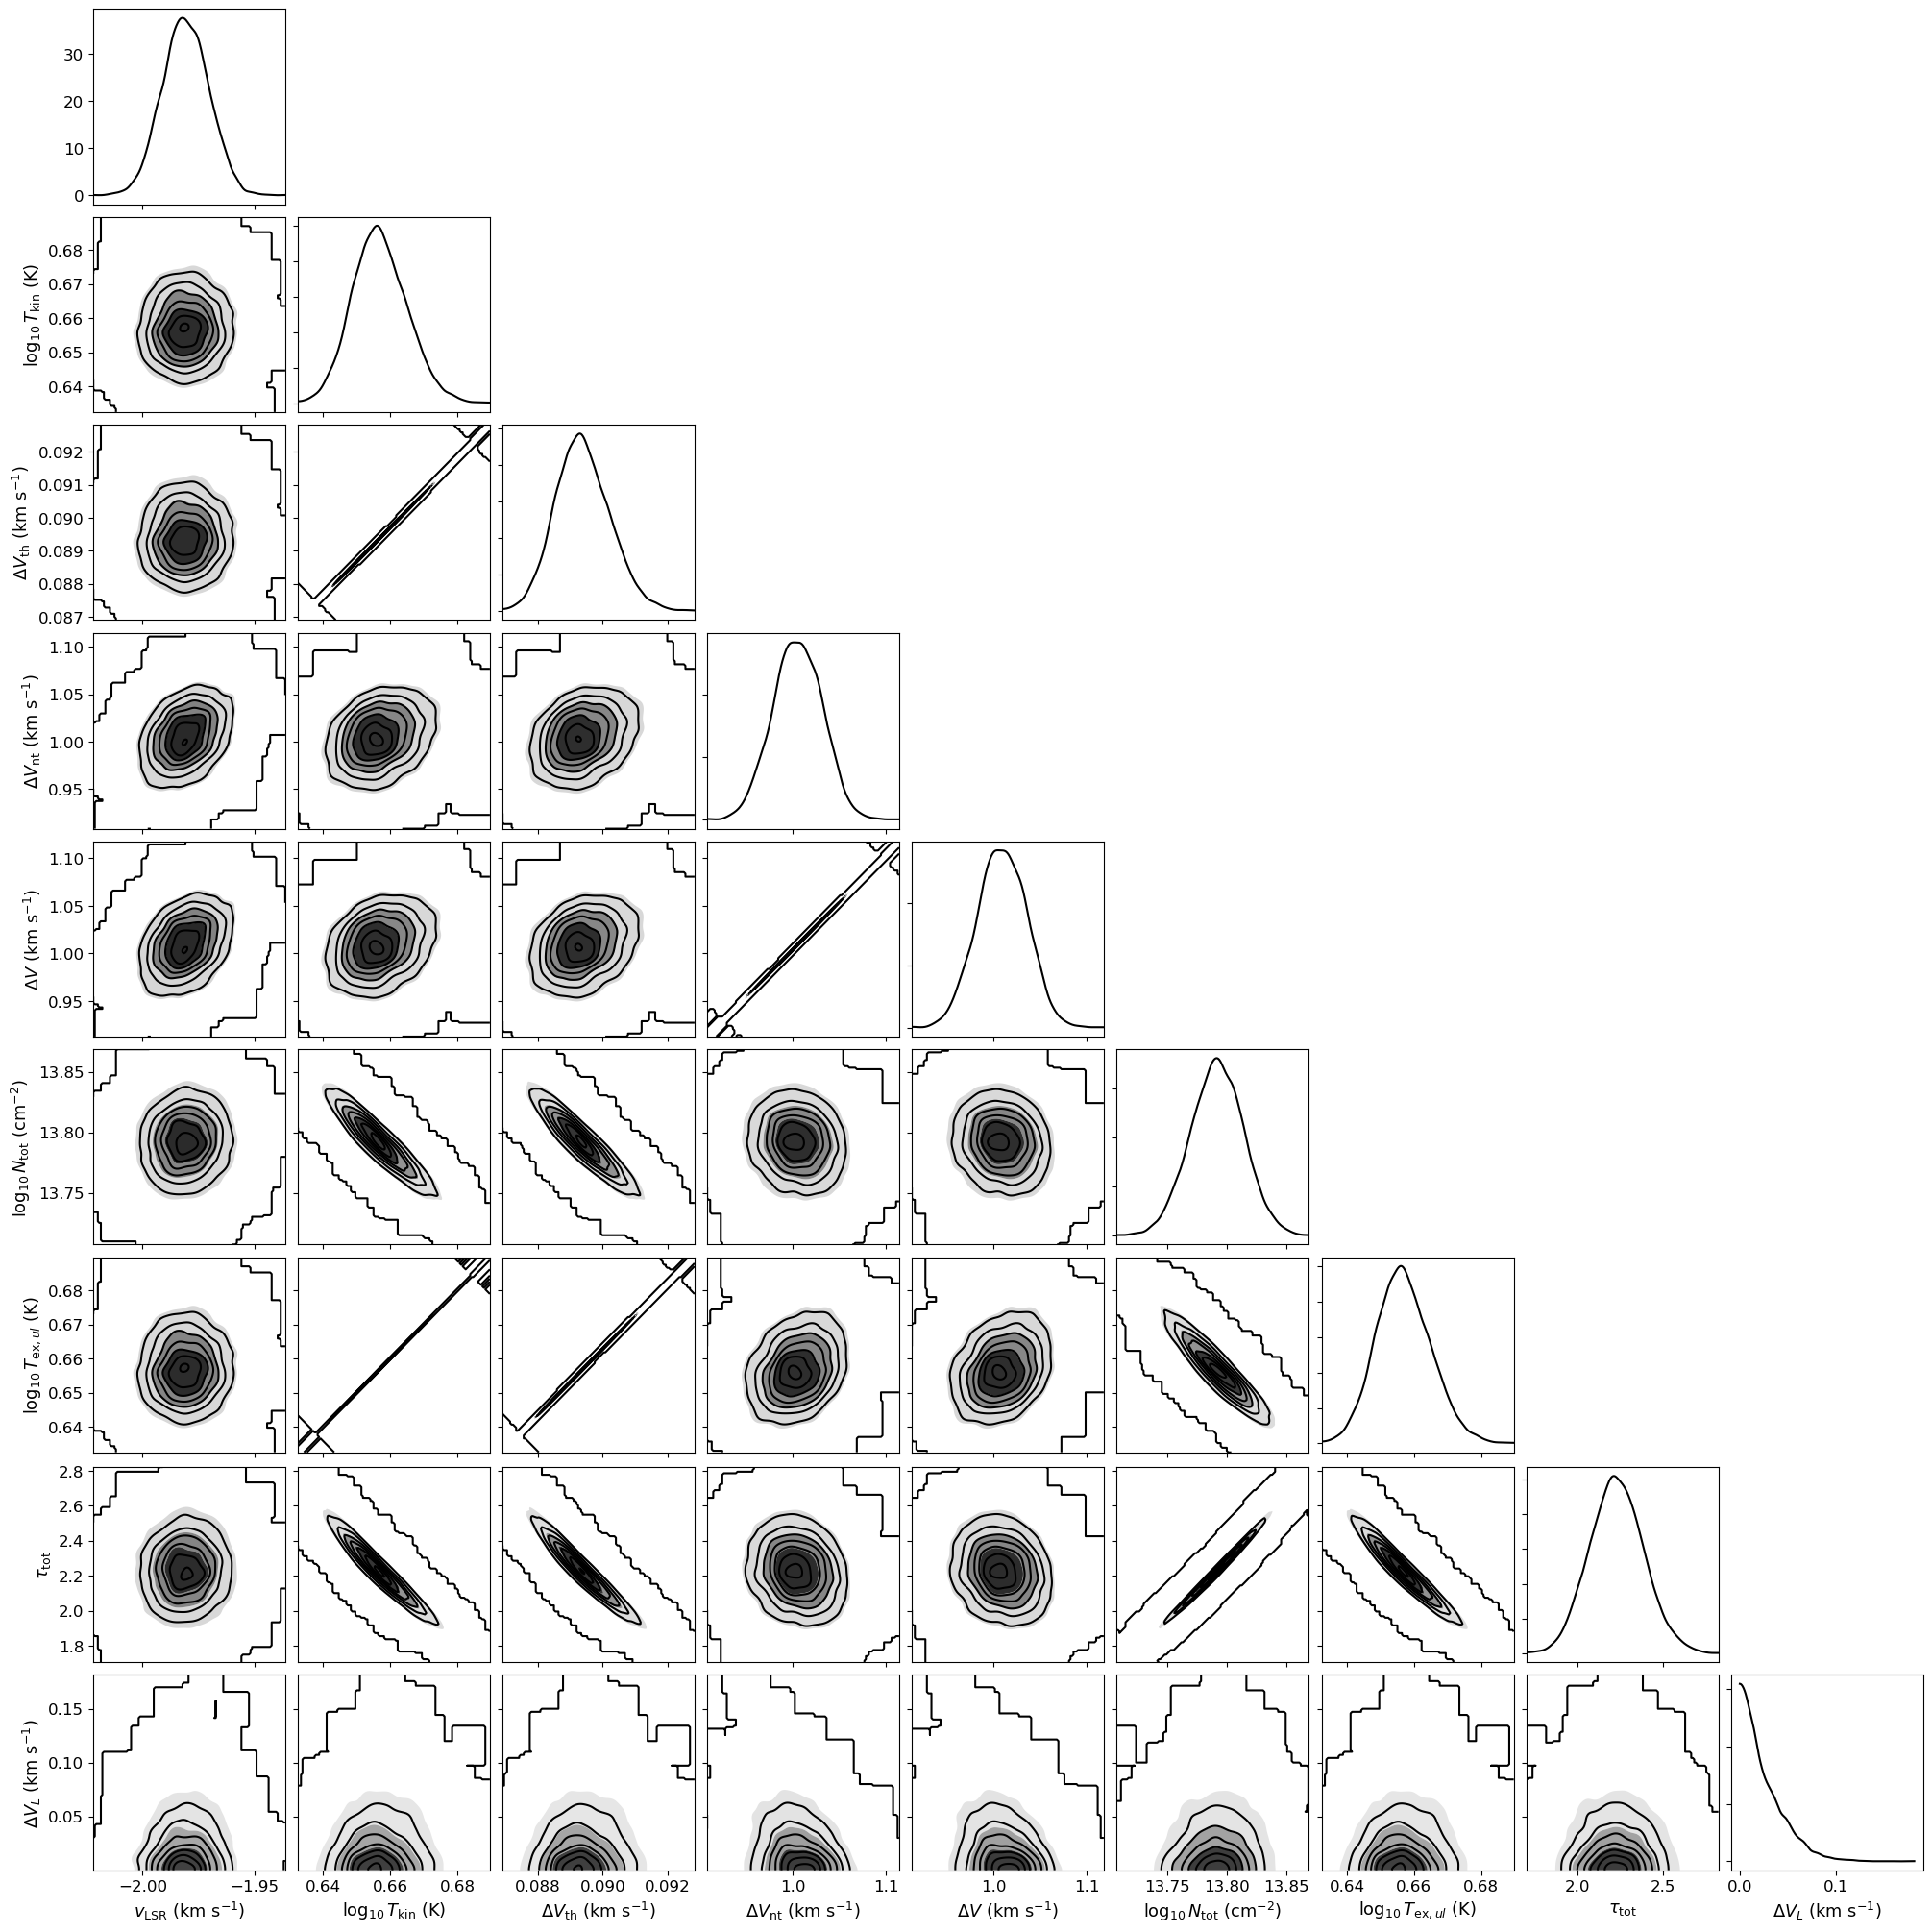

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3384.002058056953


mean     sd  hdi_16%  hdi_84%
velocity[0]               2.536  0.036    2.502    2.573
velocity[1]               0.007  0.015   -0.006    0.024
velocity[2]              -1.981  0.010   -1.992   -1.971
log10_Tkin[0]             0.502  0.006    0.496    0.507
log10_Tkin[1]             0.610  0.007    0.603    0.617
log10_Tkin[2]             0.657  0.008    0.649    0.665
fwhm_thermal[0]           0.075  0.001    0.074    0.075
fwhm_thermal[1]           0.085  0.001    0.084    0.085
fwhm_thermal[2]           0.089  0.001    0.089    0.090
fwhm_nonthermal[0]        1.452  0.091    1.348    1.527
fwhm_nonthermal[1]        1.290  0.042    1.243    1.324
fwhm_nonthermal[2]        1.005  0.027    0.979    1.032
fwhm[0]                   1.454  0.091    1.350    1.529
fwhm[1]                   1.293  0.041    1.246    1.327
fwhm[2]                   1.009  0.026    0.983    1.036
log10_N[0]               13.967  0.062   13.913   14.034
log10_N[1]               13.876  0.026   13.853   13.904
log10_N[2]               13.792  0.022   13.771   13.815
log10_Tex_ul[0]           0.502  0.006    0.496    0.507
log10_Tex_ul[1]           0.610  0.007    0.603    0.617
log10_Tex_ul[2]           0.657  0.008    0.649    0.665
Tex[113123.3687, 0]       3.179  0.045    3.130    3.214
Tex[113123.3687, 1]       4.078  0.067    4.011    4.143
Tex[113123.3687, 2]       4.539  0.086    4.452    4.619
Tex[113144.19, 0]         3.179  0.045    3.130    3.214
Tex[113144.19, 1]         4.078  0.067    4.011    4.143
Tex[113144.19, 2]         4.539  0.086    4.452    4.619
Tex[113170.535, 0]        3.179  0.045    3.130    3.214
Tex[113170.535, 1]        4.078  0.067    4.011    4.143
Tex[113170.535, 2]        4.539  0.086    4.452    4.619
Tex[113191.325, 0]        3.179  0.045    3.130    3.214
Tex[113191.325, 1]        4.078  0.067    4.011    4.143
Tex[113191.325, 2]        4.539  0.086    4.452    4.619
Tex[113488.142, 0]        3.179  0.045    3.130    3.214
Tex[113488.142, 1]        4.078  0.067    4.011    4.143
Tex[113488.142, 2]        4.539  0.086    4.452    4.619
Tex[113490.985, 0]        3.179  0.045    3.130    3.214
Tex[113490.985, 1]        4.078  0.067    4.011    4.143
Tex[113490.985, 2]        4.539  0.086    4.452    4.619
Tex[113499.643, 0]        3.179  0.045    3.130    3.214
Tex[113499.643, 1]        4.078  0.067    4.011    4.143
Tex[113499.643, 2]        4.539  0.086    4.452    4.619
Tex[113508.934, 0]        3.179  0.045    3.130    3.214
Tex[113508.934, 1]        4.078  0.067    4.011    4.143
Tex[113508.934, 2]        4.539  0.086    4.452    4.619
Tex[113520.4215, 0]       3.179  0.045    3.130    3.214
Tex[113520.4215, 1]       4.078  0.067    4.011    4.143
Tex[113520.4215, 2]       4.539  0.086    4.452    4.619
tau[113123.3687, 0]       0.059  0.009    0.049    0.067
tau[113123.3687, 1]       0.037  0.003    0.034    0.039
tau[113123.3687, 2]       0.027  0.002    0.025    0.029
tau[113144.19, 0]         0.482  0.074    0.400    0.546
tau[113144.19, 1]         0.300  0.023    0.277    0.322
tau[113144.19, 2]         0.220  0.015    0.203    0.234
tau[113170.535, 0]        0.471  0.072    0.391    0.533
tau[113170.535, 1]        0.293  0.022    0.271    0.315
tau[113170.535, 2]        0.215  0.015    0.199    0.229
tau[113191.325, 0]        0.612  0.094    0.508    0.692
tau[113191.325, 1]        0.380  0.029    0.352    0.408
tau[113191.325, 2]        0.279  0.020    0.258    0.297
tau[113488.142, 0]        0.614  0.094    0.509    0.694
tau[113488.142, 1]        0.382  0.029    0.353    0.410
tau[113488.142, 2]        0.280  0.020    0.259    0.298
tau[113490.985, 0]        1.630  0.251    1.353    1.845
tau[113490.985, 1]        1.014  0.076    0.938    1.089
tau[113490.985, 2]        0.744  0.052    0.688    0.791
tau[113499.643, 0]        0.484  0.074    0.402    0.548
tau[113499.643, 1]        0.301  0.023    0.279    0.323
tau[113499.643, 2]        0.221  0.016    0.204    0.235
tau[113508.934, 0]        0.473  0.07

In [23]:
print(sim_params)
print(derived_params)

{'log10_N': [13.8, 13.9, 14.0], 'log10_Tkin': [0.65, 0.6, 0.5], 'fwhm_nonthermal': [1.0, 1.25, 1.5], 'velocity': [-2.0, 0.0, 2.5], 'fwhm_L': 0.0, 'baseline_12CN-1_norm': [-2.0, -5.0, 8.0], 'baseline_12CN-2_norm': [4.0, -2.0, 5.0]}
{'Tex': array([[4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766],
       [4.46683592, 3.98107171, 3.16227766]]), 'tau': array([[0.02780937, 0.03961643, 0.06312223],
       [0.22764058, 0.32429648, 0.51673788],
       [0.2223333 , 0.31672379, 0.5046276 ],
       [0.28871089, 0.41128963, 0.65532851],
       [0.28981529, 0.41280405, 0.65753902],
       [0.76986139, 1.09659601, 1.7468342 ],
       [0.22866526, 0.32570236, 0.51879336],
       [0.22339835, 0.31820796, 